In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath
import cmocean

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os

import gsw
import pyresample
from xgcm import Grid

from dask.distributed import Client
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45323,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:40705,Total threads: 4
Dashboard: /proxy/33945/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:34293,


In [3]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
cor_10km = dg.variables["f"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()

## Comparison waom10 ROMSIceShelfFISOC x ROMSIceShelf_devel

In [6]:
%%time
path_old_10km = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_00*.nc'

ds = xr.open_mfdataset(paths=path_old_10km)#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_10kmOC= ds.variables["temp"]
salt_10kmOC= ds.variables["salt"]
zeta_10kmOC= ds.variables["zeta"]
melt_10kmOC= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10kmOC = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10kmOC = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 8.13 s, sys: 2.42 s, total: 10.5 s
Wall time: 34.8 s


In [7]:
%%time
path_new_10km = '/scratch/gi0/fbd581/waom10extend_testcode/waom10extend_testcode/output_01-20yr/ocean_avg_00*.nc'

ds = xr.open_mfdataset(paths=path_old_10km)#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp_10kmNC= ds.variables["temp"]
salt_10kmNC= ds.variables["salt"]
zeta_10kmNC= ds.variables["zeta"]
melt_10kmNC= ds.variables["m"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho_10kmNC = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w_10kmNC = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice
del Zo_rho, Zo_w
ds.close()



CPU times: user 6.07 s, sys: 1.05 s, total: 7.12 s
Wall time: 13.8 s


In [13]:
mask_zice_10km = ma.masked_where(zice_10km < 0, np.ones(zice_10km.shape))
mask_outice_10km = ma.masked_where(zice_10km >= 0, np.ones(zice_10km.shape))
mask_shelf_10km = ma.masked_where(h_10km > 2000, np.ones(zice_10km.shape))


In [14]:
# load 1500 and calving front contours:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_10km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_10km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km_CF = ds.variables["two"]
ds.close()

In [10]:
temp_diffK = (temp_10kmNC.mean('ocean_time')+273.15) - (temp_10kmOC.mean('ocean_time')+273.15)

In [11]:
temp_diffK

<xarray.Variable (s_rho: 31, eta_rho: 560, xi_rho: 630)>
dask.array<sub, shape=(31, 560, 630), dtype=float32, chunksize=(31, 560, 630), chunktype=numpy.ndarray>

In [15]:
fig_path='/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Maps_validations/'


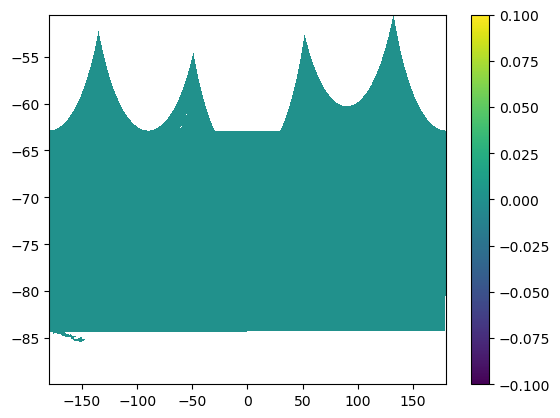

In [12]:
plt.pcolormesh(lon_rho_10km,lat_rho_10km,temp_diffK.isel(s_rho=0))
plt.colorbar()
